In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette("husl")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

### SUMMARY OF THE PROJECT:
The e-charging requests (from cars) are served with energy coming from the PV, the local battery, and/or the external grid. The system is programmed to avoid that the power drawn from the external grid exceeds the value of a threshold (“DEMAND_LIMIT”). This is known as peak-shaving, e.g., when the power drawn from the grid exceeds the DEMAND_LIMIT threshold, the local battery starts being used providing energy to “shave the peak”. Obviously, this cannot happen always and sometimes the threshold is violated (e.g., when several cars are attached, and the local battery has a low state of charge). In the data you can see when and how often this happens.

### The goal of the project is to perform “knowledge-base completion” and rule learning, possibly with neuro-symbolic approaches.
 
For ground truth, at the moment the following rules are applied for the behavior of the local battery, based on its State-Of-Charge (SOC):
SOC > 80%: e-cars charging is completely covered by the local battery
40% < SOC < 80%:
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
SOC < 40%:
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
SOC < 15%: Battery discharging is stopped due to battery health

### Research Questions:
If the values above are not specified, can we learn them? E.g. with Hybrid AI / Neuro-symbolic approaches? (knowledge base completion with LNN?)

Are there other rules in the microgrid, that can be learned from the data?


Once the rules are learned and the values above are found (e.g., 15%, 40%, 80% thresholds), is it possible to find better values, e.g., that minimize the risk of violating the DEMAND_LIMIT?


One potential idea is to specify the rules in term of logic formula and learn/complete/optimize them with Neuro-symbolic AI.

In [7]:
staticLimit = pd.read_csv('Stud_E-mobility_data_staticLimit.csv')

In [8]:
staticLimit.head(20)

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
0,2023-10-05 00:01:00+00:00,1.244171,50.0,1.0,40.5,-0.338,0.000000,0.0,0.008693,0.0,...,0.000000,0.006914,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.154965
1,2023-10-05 00:02:00+00:00,1.244171,50.0,1.0,40.5,-0.372,0.000000,0.0,0.008693,0.0,...,0.000000,0.007550,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.155586
2,2023-10-05 00:03:00+00:00,1.244171,50.0,1.0,40.5,-0.393,0.000000,0.0,0.008693,0.0,...,0.000000,0.006996,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157340
3,2023-10-05 00:04:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008693,0.0,...,0.000000,0.007392,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.158009
4,2023-10-05 00:05:00+00:00,1.244171,50.0,1.0,40.5,-0.371,0.000000,0.0,0.008693,0.0,...,0.000000,0.007188,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.158804
5,2023-10-05 00:06:00+00:00,1.339874,50.0,1.0,40.5,-0.477,0.000000,0.0,0.008693,0.0,...,0.000000,0.007132,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158213
6,2023-10-05 00:07:00+00:00,1.339874,50.0,1.0,40.5,-0.373,0.000000,0.0,0.008693,0.0,...,0.000000,0.007680,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158075
7,2023-10-05 00:08:00+00:00,1.244171,50.0,1.0,40.5,-0.359,0.000000,0.0,0.008550,0.0,...,0.000977,0.006988,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.156482
8,2023-10-05 00:09:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008550,0.0,...,0.000000,0.007089,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.156322
9,2023-10-05 00:10:00+00:00,1.244171,50.0,1.0,40.5,-0.292,0.000000,0.0,0.008633,0.0,...,0.000000,0.007034,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157987


In [4]:
staticLimit.tail(20)

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
59422,2023-11-18 23:40:00+00:00,1.244171,50.0,1.0,41.0,-0.447,0.000000,0.0,0.007734,0.000000,...,0.000000,0.005391,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.157286
59423,2023-11-18 23:41:00+00:00,1.244171,50.0,1.0,41.0,-0.459,0.000000,0.0,0.007542,0.000000,...,0.000000,0.005918,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.007812,0.157555
59424,2023-11-18 23:42:00+00:00,1.148468,50.0,1.0,41.0,-0.452,0.000000,0.0,0.007542,0.000000,...,0.000000,0.006059,0.000000,0.010307,0.001953,0.010465,0.000000,0.010287,0.000000,0.156440
59425,2023-11-18 23:43:00+00:00,1.244171,50.0,1.0,41.0,-0.469,0.000000,0.0,0.007360,0.000000,...,0.000000,0.005715,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.157298
59426,2023-11-18 23:44:00+00:00,1.148468,50.0,1.0,41.0,-0.442,0.000000,0.0,0.007553,0.000000,...,0.000000,0.005604,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.007812,0.157172
59427,2023-11-18 23:45:00+00:00,1.244171,50.0,1.0,41.0,-0.442,0.000000,0.0,0.007553,0.000000,...,0.000000,0.005869,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.156478
59428,2023-11-18 23:46:00+00:00,1.244171,50.0,1.0,41.0,-0.421,0.000000,0.0,0.007553,0.000000,...,0.000000,0.006017,0.000000,0.010307,0.000000,0.010465,0.001953,0.010287,0.000000,0.157094
59429,2023-11-18 23:47:00+00:00,1.148468,50.0,1.0,41.0,-0.442,0.101562,0.0,0.007553,0.000000,...,0.001953,0.005632,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.007812,0.156897
59430,2023-11-18 23:48:00+00:00,1.052765,50.0,1.0,41.0,-0.439,0.000000,0.0,0.007606,0.000000,...,0.000000,0.006098,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.152954
59431,2023-11-18 23:49:00+00:00,1.148468,50.0,1.0,41.0,-0.421,0.000000,0.0,0.007606,0.000000,...,0.000000,0.006048,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.148245


In [9]:
staticLimit.describe()

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
count,59442.000000,59442.0,59442.0,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,...,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000
mean,16.289759,50.0,1.0,40.146942,-0.464677,0.058751,0.050882,0.725957,0.012497,0.013051,...,0.024936,1.397854,0.017482,1.015422,0.018566,1.051943,0.025252,1.435265,0.169159,9.665066
std,19.406290,0.0,0.0,5.453018,14.480506,0.358806,0.339166,1.309800,0.067592,0.324930,...,0.223362,2.768573,3.043279,2.521278,0.161284,2.722164,0.286048,3.194861,1.120542,22.522631
min,-9.283169,50.0,1.0,7.500000,-53.692001,0.000000,-0.101562,-0.039667,0.000000,0.000000,...,0.000000,-0.007193,-524.167969,0.009783,-0.017578,0.009795,0.000000,0.009802,0.000000,0.009000
25%,1.244171,50.0,1.0,40.500000,-0.482000,0.000000,0.000000,0.006161,0.000000,0.000000,...,0.000000,0.005797,0.000000,0.010202,0.000000,0.010320,0.000000,0.010211,0.000000,0.150472
50%,6.699247,50.0,1.0,40.500000,-0.351000,0.000000,0.000000,0.008210,0.000000,0.000000,...,0.000000,0.007424,0.000000,0.010252,0.000000,0.010370,0.000000,0.010260,0.000000,0.159256
75%,26.031271,50.0,1.0,41.000000,-0.225000,0.000000,0.000000,0.887282,0.015625,0.000000,...,0.029297,1.606894,0.000977,0.010340,0.000977,0.010431,0.001953,0.010552,0.007812,0.169050
max,112.929680,50.0,1.0,54.500000,72.433006,65.699219,55.500000,7.470151,14.628906,76.445312,...,40.796875,11.713392,524.398438,11.637885,31.630859,11.531826,68.082031,11.560207,190.648438,80.319511


In [10]:
staticLimit.columns

Index(['_time', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
       'DEMAND_LIMIT_INDICATOR', 'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER',
       'WALLBOX_1_ENERGY', 'WALLBOX_1_POWER', 'WALLBOX_2_ENERGY',
       'WALLBOX_2_POWER', 'WALLBOX_3_ENERGY', 'WALLBOX_3_POWER',
       'WALLBOX_A_ENERGY', 'WALLBOX_A_POWER', 'WALLBOX_B_ENERGY',
       'WALLBOX_B_POWER', 'WALLBOX_C_ENERGY', 'WALLBOX_C_POWER',
       'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_FASTCHARGER_POWER'],
      dtype='object')

In [11]:
data_for_corr = staticLimit[['GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
       'DEMAND_LIMIT_INDICATOR', 'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER',
       'WALLBOX_1_ENERGY', 'WALLBOX_1_POWER', 'WALLBOX_2_ENERGY',
       'WALLBOX_2_POWER', 'WALLBOX_3_ENERGY', 'WALLBOX_3_POWER',
       'WALLBOX_A_ENERGY', 'WALLBOX_A_POWER', 'WALLBOX_B_ENERGY',
       'WALLBOX_B_POWER', 'WALLBOX_C_ENERGY', 'WALLBOX_C_POWER',
       'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_FASTCHARGER_POWER']]

In [12]:
full_correlation = data_for_corr.corr()

In [13]:
full_correlation

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
GARAGE_EXTERNAL_POWER,1.000000,NaN,NaN,-0.508970,0.008528,0.224724,0.247573,0.191564,0.063723,0.048859,...,0.041429,0.211282,0.002465,0.182052,0.054448,0.196256,0.049241,0.280510,0.236171,0.717202
DEMAND_LIMIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEMAND_LIMIT_INDICATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BATTERY_SOC,-0.508970,NaN,NaN,1.000000,0.012611,-0.137793,-0.144498,-0.054154,-0.017102,-0.042671,...,-0.025288,-0.124177,-0.001597,-0.116676,-0.036523,-0.130682,-0.013417,-0.074131,-0.116157,-0.342181
BATTERY_DISCHARGE_POWER,0.008528,NaN,NaN,0.012611,1.000000,-0.355790,0.323984,0.029900,0.009843,0.012303,...,0.004652,0.021858,-0.000007,-0.000615,0.014337,0.050392,0.004017,0.021766,0.206878,0.626435
BATTERY_CHARGED_ENERGY,0.224724,NaN,NaN,-0.137793,-0.355790,1.000000,0.746920,0.020929,0.373738,0.756976,...,0.715906,0.008715,0.014519,0.018032,0.507266,0.003505,0.762786,0.027945,0.795925,-0.044423
BATTERY_DISCHARGED_ENERGY,0.247573,NaN,NaN,-0.144498,0.323984,0.746920,1.000000,0.043309,0.375188,0.692916,...,0.660362,0.024409,0.019065,0.019536,0.508336,0.039157,0.691971,0.044369,0.959359,0.395467
PV_POWER,0.191564,NaN,NaN,-0.054154,0.029900,0.020929,0.043309,1.000000,0.318672,0.021055,...,0.029665,0.155326,0.002657,0.198989,0.051721,0.196261,0.021172,0.125036,0.045467,0.147428
PV_ENERGY,0.063723,NaN,NaN,-0.017102,0.009843,0.373738,0.375188,0.318672,1.000000,0.430028,...,0.416140,0.054374,0.010849,0.062566,0.452497,0.061771,0.292790,0.040689,0.391535,0.045271
WALLBOX_ALPHA_ENERGY,0.048859,NaN,NaN,-0.042671,0.012303,0.756976,0.692916,0.021055,0.430028,1.000000,...,0.757892,0.017576,0.002377,0.015413,0.422860,0.010970,0.946401,0.021944,0.713218,0.011833


In [14]:

correlation = staticLimit[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER']].corr()
print(correlation)


                       BATTERY_SOC  GARAGE_EXTERNAL_POWER
BATTERY_SOC                1.00000               -0.50897
GARAGE_EXTERNAL_POWER     -0.50897                1.00000


## Data inspection and segmentation

In [15]:
missing_values = staticLimit.isnull().sum()
data_types = staticLimit.dtypes

In [16]:
missing_values, data_types

(_time                         0
 GARAGE_EXTERNAL_POWER         0
 DEMAND_LIMIT                  0
 DEMAND_LIMIT_INDICATOR        0
 BATTERY_SOC                   0
 BATTERY_DISCHARGE_POWER       0
 BATTERY_CHARGED_ENERGY        0
 BATTERY_DISCHARGED_ENERGY     0
 PV_POWER                      0
 PV_ENERGY                     0
 WALLBOX_ALPHA_ENERGY          0
 WALLBOX_ALPHA_POWER           0
 WALLBOX_1_ENERGY              0
 WALLBOX_1_POWER               0
 WALLBOX_2_ENERGY              0
 WALLBOX_2_POWER               0
 WALLBOX_3_ENERGY              0
 WALLBOX_3_POWER               0
 WALLBOX_A_ENERGY              0
 WALLBOX_A_POWER               0
 WALLBOX_B_ENERGY              0
 WALLBOX_B_POWER               0
 WALLBOX_C_ENERGY              0
 WALLBOX_C_POWER               0
 WALLBOX_FASTCHARGER_ENERGY    0
 WALLBOX_FASTCHARGER_POWER     0
 dtype: int64,
 _time                          object
 GARAGE_EXTERNAL_POWER         float64
 DEMAND_LIMIT                  float64
 DEMAND_LI

In [17]:
staticLimit['_time'] = pd.to_datetime(staticLimit['_time'], utc=True)

In [18]:
def battery_usage(row):
    if row['BATTERY_SOC'] > 80:
        return 'Discharge for all needs'
    elif 40 < row['BATTERY_SOC'] <= 80:
        if row['GARAGE_EXTERNAL_POWER'] > row['DEMAND_LIMIT']:
            return 'Discharge for demand'
        else:
            return 'Standby'
    elif 15 <= row['BATTERY_SOC'] <= 40:
        if row['GARAGE_EXTERNAL_POWER'] > row['DEMAND_LIMIT']:
            return 'Discharge for demand'
        else:
            return 'Charge from grid'
    else:  # SOC < 15%
        return 'No discharge'

In [19]:

staticLimit['BATTERY_USAGE'] = staticLimit.apply(battery_usage, axis=1)

In [20]:
# Check for demand limit violations and when the battery discharges to mitigate it
staticLimit['DEMAND_VIOLATION'] = staticLimit['GARAGE_EXTERNAL_POWER'] > staticLimit['DEMAND_LIMIT']
staticLimit['BATTERY_DISCHARGE_ACTION'] = (staticLimit['DEMAND_VIOLATION'] & (staticLimit['BATTERY_DISCHARGE_POWER'] < 0))


In [21]:
violations_summary = staticLimit['DEMAND_VIOLATION'].value_counts(normalize=True)
battery_actions_summary = staticLimit['BATTERY_DISCHARGE_ACTION'].value_counts(normalize=True)


In [22]:
violations_summary, battery_actions_summary

(DEMAND_VIOLATION
 False    0.923455
 True     0.076545
 Name: proportion, dtype: float64,
 BATTERY_DISCHARGE_ACTION
 False    0.977255
 True     0.022745
 Name: proportion, dtype: float64)

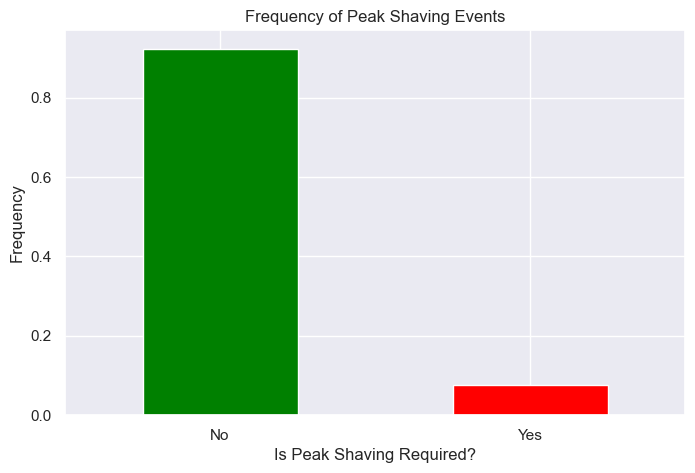

PEAK_SHAVING_REQUIRED
False    0.923455
True     0.076545
Name: proportion, dtype: float64

In [23]:
# Calculating  and flag the instances where the grid power exceeds the demand limit
staticLimit['PEAK_SHAVING_REQUIRED'] = staticLimit['GARAGE_EXTERNAL_POWER'] > staticLimit['DEMAND_LIMIT']
peak_shaving_stats = staticLimit['PEAK_SHAVING_REQUIRED'].value_counts(normalize=True)
plt.figure(figsize=(8, 5))
peak_shaving_stats.plot(kind='bar', color=['green', 'red'])
plt.title('Frequency of Peak Shaving Events')
plt.xlabel('Is Peak Shaving Required?')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.show()

peak_shaving_stats

About $7.65$% of the time, the power drawn from the external grid exceeds the demand limit, indicating that peak-shaving is required. This suggests that the system generally manages to keep the external power draw within limits most of the time, but there are still notable instances where intervention via battery discharge or other measures is necessary.

The local battery discharges to mitigate these demand violations about $2.27$% of the time. This is relatively low compared to the number of violations, suggesting that the battery might often be at a lower state of charge (SOC) or other conditions prevent it from discharging (e.g., SOC below 15%).

These insights suggest that while there is a mechanism in place for the battery to help manage peak demand, it might not always be effective due to various constraints such as battery SOC or multiple simultaneous charging requests.

The data indicates a slightly higher activity on Saturdays and Thursdays. The lowest activity occurs on Tuesdays. This pattern could reflect variations in travel or usage patterns during different days of the week.

There's a significant difference between weekday and weekend entries, with weekdays seeing more activity. This suggests that the charging facilities are utilized more during the weekdays, which could be linked to regular commuting or commercial activity patterns.

Most entries fall within the 15% - 40% SOC range, indicating that the battery often operates within this range. The very few entries above 80% SOC suggest that the battery rarely is fully charged, or such high charge levels are quickly utilized. Notably, there are no entries with SOC below 15%, which aligns with the operational constraint that discharging is stopped at SOC below 15% to protect battery health.

### Analyzing how often GARAGE_EXTERNAL_POWER exceeds DEMAND_LIMIT and the conditions around these events, such as the BATTERY_SOC.

In [24]:
staticLimit['DEMAND_VIOLATION'] = staticLimit['GARAGE_EXTERNAL_POWER'] > staticLimit['DEMAND_LIMIT']
total_violations = staticLimit['DEMAND_VIOLATION'].sum()
violation_data = staticLimit[staticLimit['DEMAND_VIOLATION']]
violation_soc_stats = violation_data['BATTERY_SOC'].describe()

In [25]:
total_violations, violation_soc_stats

(4550,
 count    4550.000000
 mean       34.901319
 std         7.896293
 min         7.500000
 25%        32.000000
 50%        36.000000
 75%        39.500000
 max        54.500000
 Name: BATTERY_SOC, dtype: float64)

There are **4,550 instances** where the power drawn from the external grid (GARAGE_EXTERNAL_POWER) exceeds the set DEMAND_LIMIT.

- **Mean SOC:** The average state of charge of the battery during these violations is approximately **34.9%**.
- **Standard Deviation:** The SOC values show a standard deviation of about **7.9%**, indicating moderate variability.
- **Minimum SOC:** The lowest recorded SOC during a violation is **7.5%**, which is below the critical limit of 15% where battery discharging should be stopped.
- **Maximum SOC:** The highest SOC during these events is **54.5%**, which is interesting as it suggests that even at relatively high SOC levels, violations can occur.
- **25th Percentile:** 32.0%, suggesting that a quarter of the violations occur with the battery SOC at or below **32%**.
- **50th Percentile (Median):** 36.0%, indicating that half of the violations occur with the battery SOC at or below **36%**.
- **75th Percentile:** 39.5%, showing that 75% of the violations occur with the battery SOC at or below **39.5%**.

###  Filter data for SOC ranges

In [26]:
#Filter data for SOC ranges:>80%
high_soc_violations = staticLimit[(staticLimit['BATTERY_SOC'] > 80) & (staticLimit['DEMAND_VIOLATION'])]
high_soc_analysis = high_soc_violations[['PV_POWER', 'BATTERY_DISCHARGE_POWER', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT']]
wallbox_columns = [col for col in staticLimit.columns if 'WALLBOX' in col and 'POWER' in col]
high_soc_analysis['TOTAL_WALLBOX_POWER'] = high_soc_violations[wallbox_columns].sum(axis=1)
high_soc_summary = high_soc_analysis.describe()
high_soc_summary

,PV_POWER,BATTERY_DISCHARGE_POWER,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,TOTAL_WALLBOX_POWER
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


In [27]:
#Filter data for SOC ranges: 40-80% and <40%
mid_range_violations = staticLimit[(staticLimit['BATTERY_SOC'] > 40) & (staticLimit['BATTERY_SOC'] <= 80) & (staticLimit['DEMAND_VIOLATION'])]
low_range_violations = staticLimit[(staticLimit['BATTERY_SOC'] <= 40) & (staticLimit['BATTERY_SOC'] > 15) & (staticLimit['DEMAND_VIOLATION'])]
very_low_range_violations = staticLimit[ (staticLimit['BATTERY_SOC'] <= 15) & (staticLimit['DEMAND_VIOLATION'])]
def summarize_violations(violation_data):
    summary = {
        'Total Violations': violation_data.shape[0],
        'Mean Battery Discharge Power': violation_data['BATTERY_DISCHARGE_POWER'].mean(),
        'Mean PV Power': violation_data['PV_POWER'].mean()
    }
    total_wallbox_power = violation_data[wallbox_columns].sum(axis=1).mean()
    summary['Mean Total Wallbox Power'] = total_wallbox_power
    return summary

mid_range_summary = summarize_violations(mid_range_violations)
low_range_summary = summarize_violations(low_range_violations)
very_low_range_summary = summarize_violations(very_low_range_violations)

mid_range_summary, low_range_summary, very_low_range_summary

({'Total Violations': 579,
  'Mean Battery Discharge Power': 13.063781278680395,
  'Mean PV Power': 1.5134579774918773,
  'Mean Total Wallbox Power': 64.71302796691218},
 {'Total Violations': 3873,
  'Mean Battery Discharge Power': 11.958403138771342,
  'Mean PV Power': 1.211957046955862,
  'Mean Total Wallbox Power': 63.61506911567848},
 {'Total Violations': 98,
  'Mean Battery Discharge Power': 0.5497041283821573,
  'Mean PV Power': 0.9972956409313768,
  'Mean Total Wallbox Power': 72.82618042792679})

- **Mid Range SOC (40% - 80%)**: 
  - The majority of violations occur in this range, with the battery still being used to manage load.
- **Low Range SOC (15% - 40%)**:
  - The system continues to utilize the battery for peak-shaving, risking battery health as SOC drops closer to critical levels.
- **Very Low Range SOC (<15%)**:
  - Discharging is halted, which increases reliance on external grid power, potentially leading to more frequent violations.

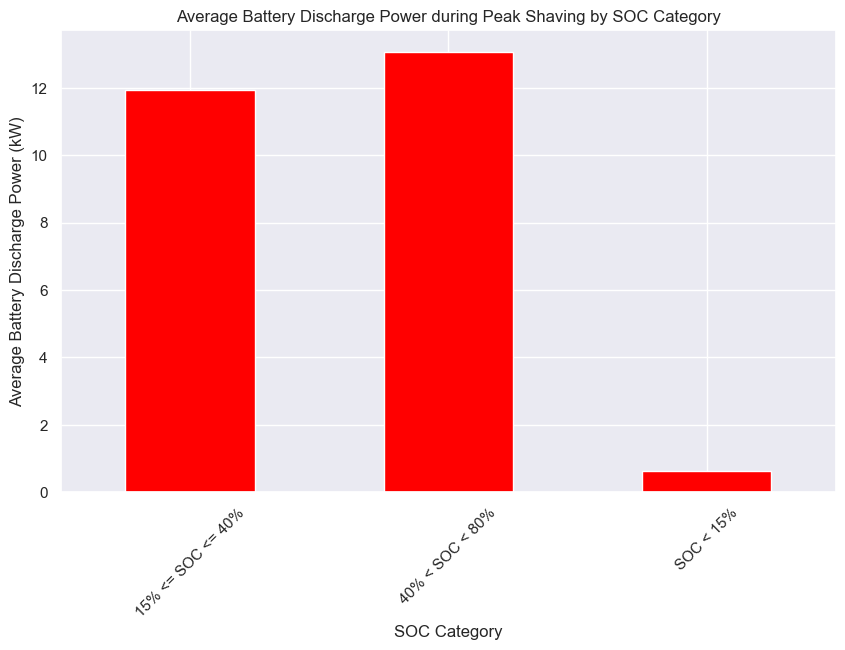

SOC_CATEGORY
15% <= SOC <= 40%    11.941547
40% < SOC < 80%      13.063781
SOC < 15%             0.639226
Name: BATTERY_DISCHARGE_POWER, dtype: float64

In [28]:
def categorize_soc(soc):
    if soc >= 80:
        return "SOC >= 80%"
    elif 40 < soc < 80:
        return "40% < SOC < 80%"
    elif 15 <= soc <= 40:
        return "15% <= SOC <= 40%"
    else:
        return "SOC < 15%"
staticLimit['SOC_CATEGORY'] = staticLimit['BATTERY_SOC'].apply(categorize_soc)
peak_shaving_data = staticLimit[staticLimit['PEAK_SHAVING_REQUIRED']]
avg_discharge_by_soc = peak_shaving_data.groupby('SOC_CATEGORY')['BATTERY_DISCHARGE_POWER'].mean()
plt.figure(figsize=(10, 6))
avg_discharge_by_soc.plot(kind='bar', color='red')
plt.title('Average Battery Discharge Power during Peak Shaving by SOC Category')
plt.xlabel('SOC Category')
plt.ylabel('Average Battery Discharge Power (kW)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

avg_discharge_by_soc

 Mid Range SOC (40% - 80%)
- **Average Battery Discharge Power:** 13.06 kW
  - This indicates active utilization of the battery for peak shaving in this SOC range, suggesting an effective use of the battery's capacity to limit external grid reliance during high demand periods.

 Lower Range SOC (15% - 40%)
- **Average Battery Discharge Power:** 11.94 kW
  - The battery continues to be actively used for peak shaving within this range, showing that even at lower levels of charge, the system tries to minimize grid power consumption to manage peak load effectively.

Very Low Range SOC (<15%)
- **Average Battery Discharge Power:** 0.64 kW
  - There is a significant drop in discharge power, which aligns with the operational guideline to stop or minimize battery discharge below 15% SOC. This strategy is implemented to preserve battery health and avoid deep discharge cycles that may degrade battery life.

## Data visualization 

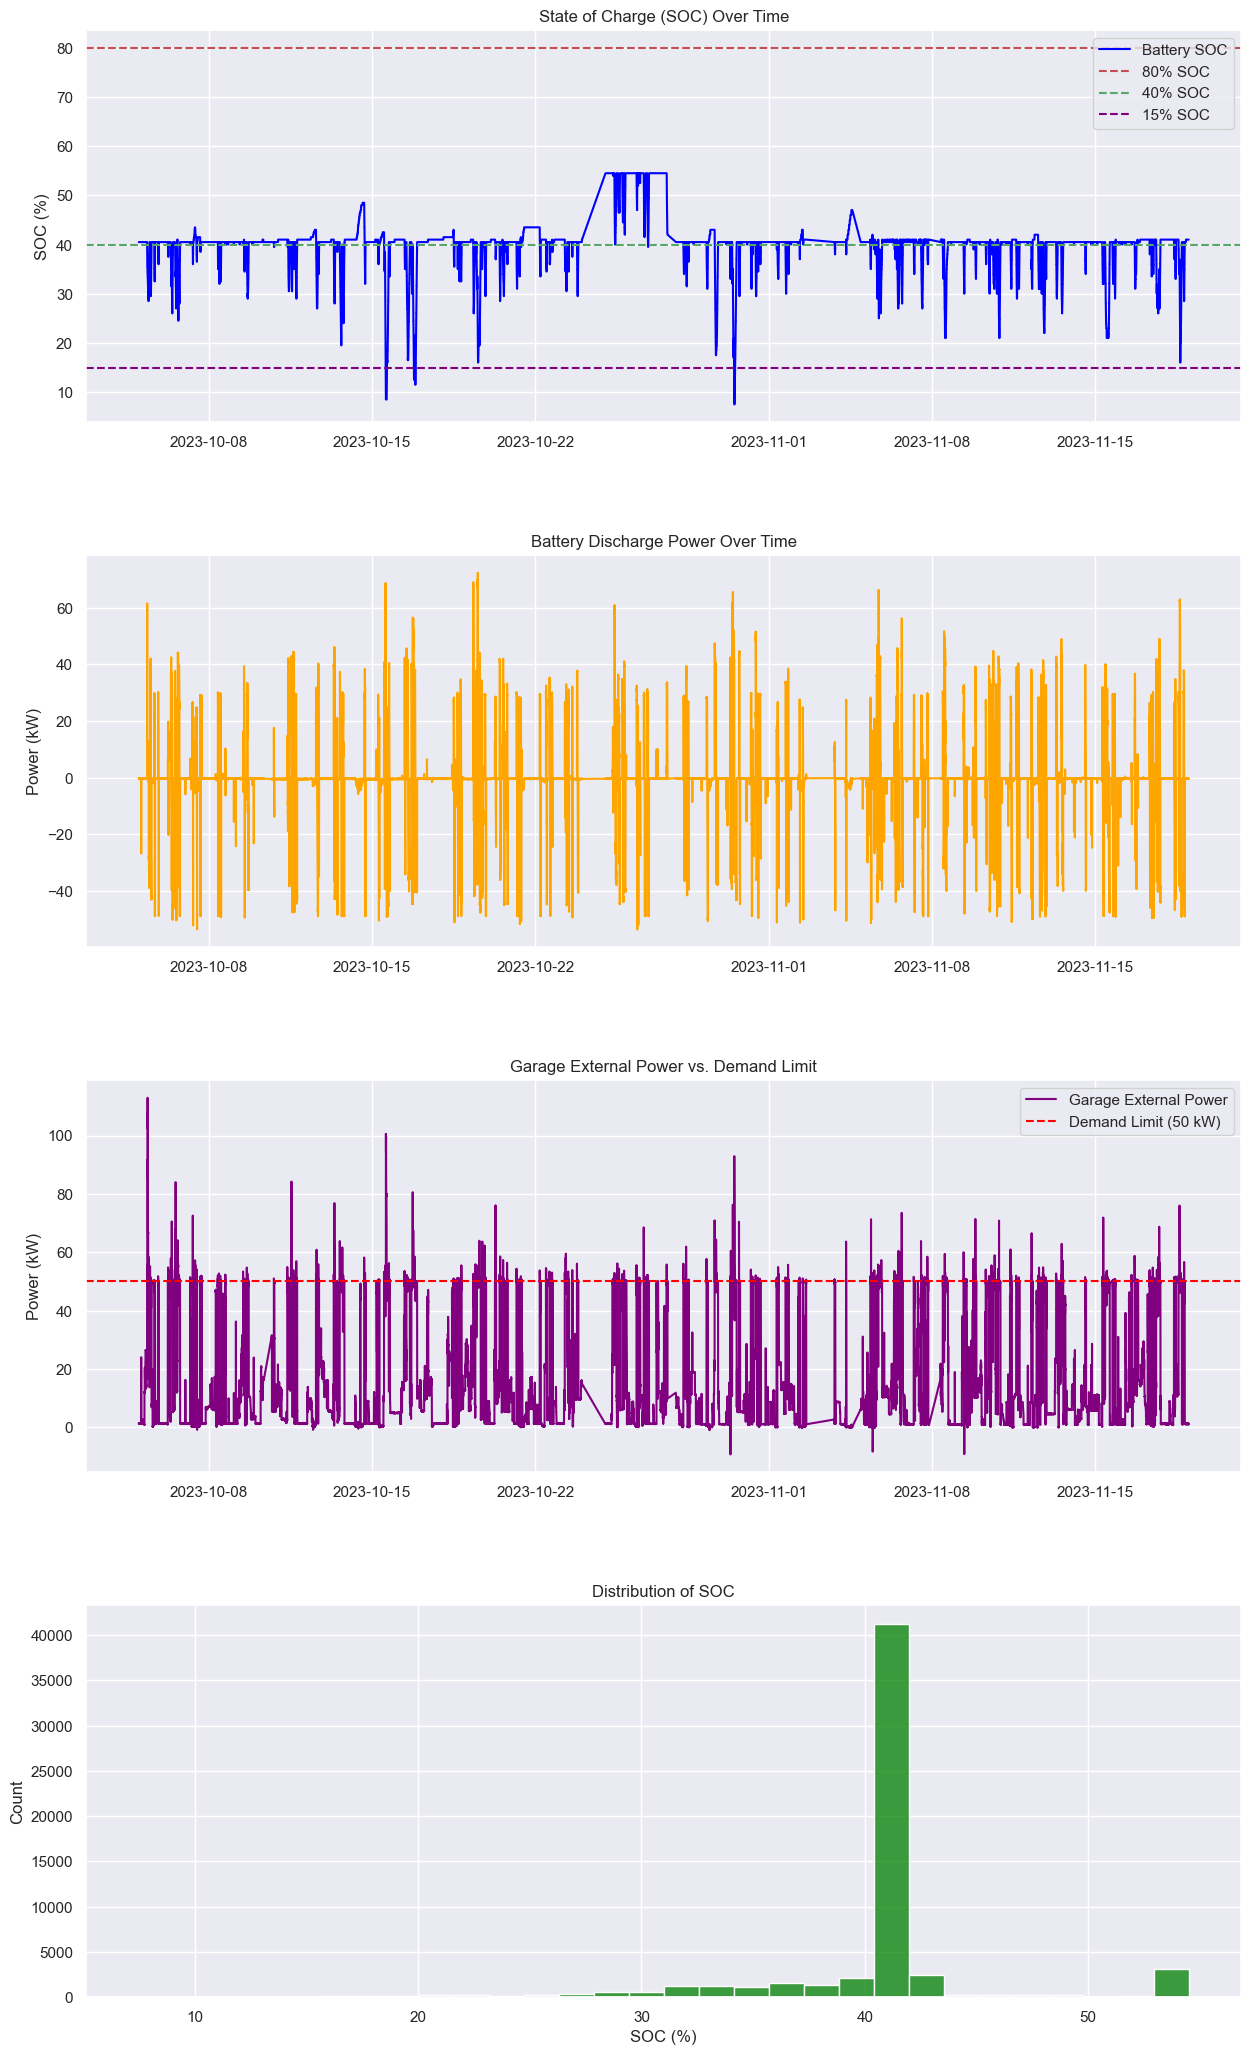

In [29]:
staticLimit['_time'] = pd.to_datetime(staticLimit['_time'])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 22))
fig.tight_layout(pad=6.0)

#SOC Over Time
axes[0].plot(staticLimit['_time'], staticLimit['BATTERY_SOC'], label='Battery SOC', color='blue')
axes[0].axhline(y=80, color='r', linestyle='--', label='80% SOC')
axes[0].axhline(y=40, color='g', linestyle='--', label='40% SOC')
axes[0].axhline(y=15, color='purple', linestyle='--', label='15% SOC')
axes[0].set_title('State of Charge (SOC) Over Time')
axes[0].set_ylabel('SOC (%)')
axes[0].legend()

# Battery Discharge/Charge Power Over Time
axes[1].plot(staticLimit['_time'], staticLimit['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='orange')
axes[1].set_title('Battery Discharge Power Over Time')
axes[1].set_ylabel('Power (kW)')

# Garage External Power vs. Demand Limit
axes[2].plot(staticLimit['_time'], staticLimit['GARAGE_EXTERNAL_POWER'], label='Garage External Power', color='purple')
axes[2].axhline(y=50, color='red', linestyle='--', label='Demand Limit (50 kW)')
axes[2].set_title('Garage External Power vs. Demand Limit')
axes[2].set_ylabel('Power (kW)')
axes[2].legend()

# Distribution of SOC
sns.histplot(staticLimit['BATTERY_SOC'], bins=30, ax=axes[3], color='green')
axes[3].set_title('Distribution of SOC')
axes[3].set_xlabel('SOC (%)')

plt.show()

### Decision tree 

I created a binary target variable indicating whether the battery is actively discharging (positive discharge power) or not. I decided to include features such as SOC, external power, and whether external power exceeds the demand limit.

In [30]:

staticLimit['is_discharging'] = staticLimit['BATTERY_DISCHARGE_POWER'] > 0
features = staticLimit[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT']]
target = staticLimit['is_discharging']
features['external_above_demand'] = features['GARAGE_EXTERNAL_POWER'] > features['DEMAND_LIMIT']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
classification_results = classification_report(y_test, y_pred)




/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_9244/3105083870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['external_above_demand'] = features['GARAGE_EXTERNAL_POWER'] > features['DEMAND_LIMIT']


In [65]:
classification_results

'              precision    recall  f1-score   support\n\n       False       0.97      0.95      0.96     15795\n        True       0.64      0.75      0.69      2038\n\n    accuracy                           0.92     17833\n   macro avg       0.81      0.85      0.82     17833\nweighted avg       0.93      0.92      0.93     17833\n'

### Test Random forest

In [32]:

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_model.fit(X_train, y_train)
y_rf_pred = random_forest_model.predict(X_test)
rf_classification_results = classification_report(y_test, y_rf_pred)
feature_importances = pd.Series(random_forest_model.feature_importances_, index=X_train.columns)
rf_classification_results, feature_importances


('              precision    recall  f1-score   support\n\n       False       0.95      0.96      0.95     15795\n        True       0.65      0.64      0.65      2038\n\n    accuracy                           0.92     17833\n   macro avg       0.80      0.80      0.80     17833\nweighted avg       0.92      0.92      0.92     17833\n',
 BATTERY_SOC              0.337163
 GARAGE_EXTERNAL_POWER    0.592464
 DEMAND_LIMIT             0.000000
 external_above_demand    0.070373
 dtype: float64)

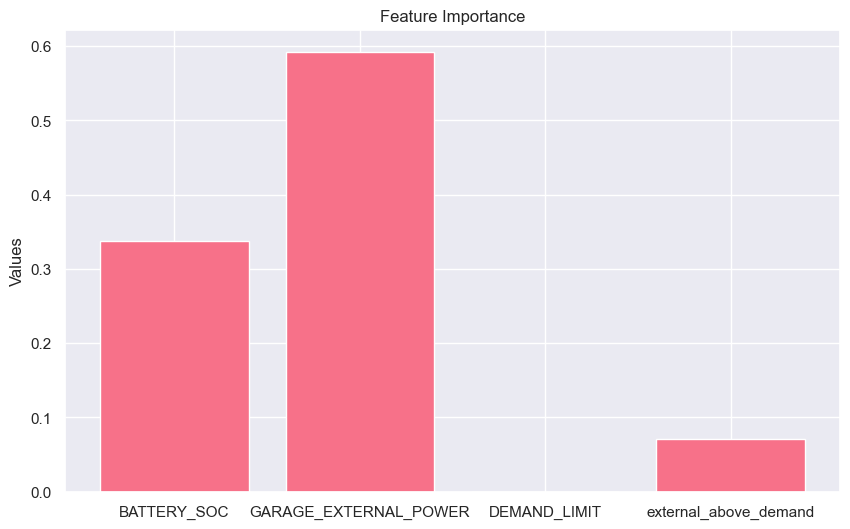

In [39]:
import matplotlib.pyplot as plt
variables = ['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT', 'external_above_demand']
values = [0.337163, 0.592464, 0.000000, 0.070373]
plt.figure(figsize=(10, 6))
plt.bar(variables, values)
plt.ylabel('Values')
plt.title('Feature Importance')
plt.show()


Interaction terms between features such as 'BATTERY_SOC' and 'GARAGE_EXTERNAL_POWER' might reveal nonlinear relationships.

In [44]:
# Ensure your dataset is named correctly; it appears it should be 'data', not 'staticLimit'
features_poly = staticLimit[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER']]
features_bins = staticLimit[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER']]
poly_features = poly.fit_transform(features_poly)
binned_features = bins.fit_transform(features_bins)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_poly.columns))
binned_features_df = pd.DataFrame(binned_features)
features.columns = features.columns.astype(str)
poly_features_df.columns = poly_features_df.columns.astype(str)
binned_features_df.columns = [f'bin_{i}' for i in range(binned_features_df.shape[1])]
X_extended = pd.concat([features, poly_features_df, binned_features_df], axis=1)
X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X_extended, target, test_size=0.3, random_state=42)
random_forest_model_extended = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model_extended.fit(X_train_ext, y_train_ext)
y_rf_pred_ext = random_forest_model_extended.predict(X_test_ext)
rf_classification_results_ext = classification_report(y_test_ext, y_rf_pred_ext)
rf_classification_results_ext


/Users/jevgenijposaskov/anaconda3/envs/my_mlenv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.95      0.95      0.95     15795\n        True       0.65      0.64      0.64      2038\n\n    accuracy                           0.92     17833\n   macro avg       0.80      0.80      0.80     17833\nweighted avg       0.92      0.92      0.92     17833\n'

These results are quite similar to the previous model without the additional features. This suggests that the original features were already capturing the most relevant information for predicting battery discharge actions, and the added complexity did not significantly enhance the model's performance.

In [46]:

scaler = StandardScaler()
features_nn = staticLimit[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER']]
features_nn = scaler.fit_transform(features_nn)
target_nn = staticLimit['BATTERY_DISCHARGE_POWER'] > 0

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(features_nn, target_nn, test_size=0.3, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(10, 5), activation='relu', random_state=42, max_iter=300)

nn_model.fit(X_train_nn, y_train_nn)
y_nn_pred = nn_model.predict(X_test_nn)
nn_classification_results = classification_report(y_test_nn, y_nn_pred)
nn_classification_results


'              precision    recall  f1-score   support\n\n       False       0.96      0.93      0.94     15795\n        True       0.55      0.67      0.61      2038\n\n    accuracy                           0.90     17833\n   macro avg       0.76      0.80      0.77     17833\nweighted avg       0.91      0.90      0.90     17833\n'

The precision for discharging cases is relatively low, which could indicate some false positives where the model predicts discharging when it shouldn't

The neural network seems to have some capability to learn the underlying patterns related to battery discharge behaviors, but there might be room for improvement

In [47]:

staticLimit['power_exceeds_limit'] = staticLimit['GARAGE_EXTERNAL_POWER'] > staticLimit['DEMAND_LIMIT']

features_nn_extended = staticLimit[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER', 'power_exceeds_limit']]
features_nn_extended = scaler.fit_transform(features_nn_extended)
X_train_nn_ext, X_test_nn_ext, y_train_nn_ext, y_test_nn_ext = train_test_split(features_nn_extended, target_nn, test_size=0.3, random_state=42)
nn_model_ext = MLPClassifier(hidden_layer_sizes=(10, 5), activation='relu', random_state=42, max_iter=300)
nn_model_ext.fit(X_train_nn_ext, y_train_nn_ext)
y_nn_pred_ext = nn_model_ext.predict(X_test_nn_ext)




In [48]:
nn_classification_results_ext = classification_report(y_test_nn_ext, y_nn_pred_ext)
nn_classification_results_ext

'              precision    recall  f1-score   support\n\n       False       0.94      0.97      0.95     15795\n        True       0.69      0.49      0.57      2038\n\n    accuracy                           0.92     17833\n   macro avg       0.81      0.73      0.76     17833\nweighted avg       0.91      0.92      0.91     17833\n'

The addition of the power_exceeds_limit feature likely helps the model to better identify situations where battery discharge should not occur, as reflected by the improved precision. However, the drop in recall could indicate that the model might be too cautious, possibly due to how the feature influences the learning process concerning other contextual data.